In [89]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


pickle_files= [
    "./masked_test_predictions_20_3.pkl",
    # "./masked_test_predictions_20_4.pkl",
    # # "./masked_test_predictions_20_4.pkl",
    # # "./masked_test_predictions_20_4.pkl",
    # "./masked_test_predictions_26.pkl",
    "./masked_test_predictions_my_model.pkl"
]
data = [pickle.load(open(path, "rb")) for path in pickle_files]

for idx, d in enumerate(data):
    print("="*60)
    print(f"File {idx+1}: {pickle_files[idx]}")
    predictions = d["predictions"]
    targets     = d["targets"]
    metadata    = d["metadata"]

    print(f"Loaded data with {metadata['total_samples']} samples")
    print(f"Predictions shape: {predictions.shape}")
    print(f"Targets shape: {targets.shape}")
    print(f"Model info: {metadata['model_info']}")
    print(f"Save logits: {metadata['save_logits']}")

    # Display some basic statistics
    print(f"\nPrediction statistics:")
    print(f"  Min: {predictions.min():.4f}")
    print(f"  Max: {predictions.max():.4f}")
    print(f"  Mean: {predictions.mean():.4f}")
    print(f"  Std: {predictions.std():.4f}")

    print(f"\nTarget statistics:")
    print(f"  Min: {targets.min():.4f}")
    print(f"  Max: {targets.max():.4f}")
    print(f"  Mean: {targets.mean():.4f}")
    print(f"  Sum: {targets.sum():.0f} (total positive labels)")

    # keep handles if you want to use them later
    pred = predictions
    targ = targets



File 1: ./masked_test_predictions_20_3.pkl
Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 21])
Targets shape: torch.Size([12000, 21])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Save logits: True

Prediction statistics:
  Min: 0.0000
  Max: 0.9722
  Mean: 0.0020
  Std: 0.0251

Target statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0248
  Sum: 6254 (total positive labels)
File 2: ./masked_test_predictions_my_model.pkl
Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 21])
Targets shape: torch.Size([12000, 21])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Save logits: True

Prediction statistics:
  Min: 0.0050
  Max: 0.9702
  Mean: 0.0683
  Std: 0.0794

Target statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0248
  Sum: 6254 (total positive labels)


In [90]:
# Convert all predictions to float32 tensors/arrays of same shape
preds_list = [d["predictions"].detach().cpu().numpy() if isinstance(d["predictions"], torch.Tensor) else d["predictions"]
              for d in data]

# stack into shape (n_models, n_samples, n_classes)
preds_stack = np.stack(preds_list, axis=0)
print("Stack shape:", preds_stack.shape)  # e.g. (3, 1000, 21)

# mean over axis=0 → (n_samples, n_classes)
preds_mean = preds_stack.mean(axis=0)
print("Ensembled predictions shape:", preds_mean.shape)

preds_list = [
    d["predictions"].detach().cpu().numpy().astype(np.float32)
    if isinstance(d["predictions"], torch.Tensor) else
    np.asarray(d["predictions"], dtype=np.float32)
    for d in data
]
preds_stack = np.stack(preds_list, axis=0)           # (n_models, N, C)
print("Stack shape:", preds_stack.shape)

preds_mean = preds_stack.mean(axis=0)                # (N, C) logits
print("Ensembled predictions shape:", preds_mean.shape)

# ---- Targets (take from first file, but sanity-check) ----
targ = data[0]["targets"]
if isinstance(targ, torch.Tensor):
    targ = targ.detach().cpu().numpy()
targ = np.asarray(targ)                              # (N, C) or (N,)
if targ.ndim == 1: targ = targ[:, None]
print("Targets shape:", targ.shape)

# Optional: verify all files have the same targets
for i, d in enumerate(data[1:], start=1):
    t = d["targets"]
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()
    t = np.asarray(t)
    if t.ndim == 1: t = t[:, None]
    if not (t.shape == targ.shape and np.array_equal(t, targ)):
        print(f"⚠️ Targets differ in file {i} ({pickle_files[i]})")

# ---- Convert logits -> probabilities (multilabel uses sigmoid) ----
# Heuristic: if values already in [0,1], treat as probabilities
pred_min, pred_max = float(preds_mean.min()), float(preds_mean.max())
already_probs = (pred_min >= 0.0) and (pred_max <= 1.0)

if already_probs:
    probs_np = preds_mean.astype(np.float32)
else:
    probs_np = expit(preds_mean.astype(np.float32))  # sigmoid for NumPy

print("pred min/max/mean BEFORE conversion:", pred_min, pred_max, float(preds_mean.mean()))
print("probs min/max/mean AFTER conversion:", float(probs_np.min()), float(probs_np.max()), float(probs_np.mean()))

# ---- Build DataFrame like raw_out.csv ----
if probs_np.ndim == 1:  probs_np = probs_np[:, None]
if targ.ndim     == 1:  targ     = targ[:, None]
assert probs_np.shape == targ.shape, f"Shape mismatch: probs {probs_np.shape} vs targets {targ.shape}"

n_classes = probs_np.shape[1]
pred_cols   = [f"prob_class_{i}"   for i in range(n_classes)]
target_cols = [f"target_class_{i}" for i in range(n_classes)]

df = pd.DataFrame(
    np.hstack([probs_np, targ]),
    columns=pred_cols + target_cols
)

print(df.head())
print("Num samples (N):", len(df), "| Classes (C):", n_classes)
print("Sum over all targets:", float(targ.sum()))
print("Per-class sums (first 20):", [int(targ[:, i].sum()) for i in range(min(n_classes, 20))])


Stack shape: (2, 12000, 21)
Ensembled predictions shape: (12000, 21)
Stack shape: (2, 12000, 21)
Ensembled predictions shape: (12000, 21)
Targets shape: (12000, 21)
pred min/max/mean BEFORE conversion: 0.0026564598083496094 0.95361328125 0.03513913229107857
probs min/max/mean AFTER conversion: 0.0026564598083496094 0.95361328125 0.03513913229107857
   prob_class_0  prob_class_1  prob_class_2  prob_class_3  prob_class_4  \
0      0.005547      0.039654      0.015760      0.021703      0.009858   
1      0.005050      0.053218      0.011808      0.008556      0.007269   
2      0.011851      0.460571      0.039906      0.056887      0.027216   
3      0.004917      0.031669      0.009795      0.008262      0.008897   
4      0.004732      0.044079      0.009606      0.011092      0.008048   

   prob_class_5  prob_class_6  prob_class_7  prob_class_8  prob_class_9  ...  \
0      0.011773      0.042274      0.017676      0.004513      0.004635  ...   
1      0.009533      0.093830      0.0

In [91]:
# Optional imports (only used if available)
try:
    from sklearn.metrics import (
        roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
        confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score,
        brier_score_loss, log_loss
    )
    SKLEARN_AVAILABLE = True
except Exception as e:
    print("scikit-learn not available; some metrics/plots will be skipped.", e)
    SKLEARN_AVAILABLE = False



prob_cols = [c for c in df.columns if c.startswith("prob_class_")]
target_cols = [c for c in df.columns if c.startswith("target_class_")]
print("Num samples (N):", len(df))
print("Probability columns:", prob_cols)
print("Probs min/max:", float(df[prob_cols].min().min()), float(df[prob_cols].max().max()))
C = len(prob_cols)
print("Detected classes (C):", C)


Num samples (N): 12000
Probability columns: ['prob_class_0', 'prob_class_1', 'prob_class_2', 'prob_class_3', 'prob_class_4', 'prob_class_5', 'prob_class_6', 'prob_class_7', 'prob_class_8', 'prob_class_9', 'prob_class_10', 'prob_class_11', 'prob_class_12', 'prob_class_13', 'prob_class_14', 'prob_class_15', 'prob_class_16', 'prob_class_17', 'prob_class_18', 'prob_class_19', 'prob_class_20']
Probs min/max: 0.0026564598083496094 0.95361328125
Detected classes (C): 21


In [92]:
Y_true = df[target_cols].values.astype(int)  # [N, C] in {0,1}
Y_prob = df[prob_cols].values.astype(float)  # [N, C] in [0,1]
# Per-class AUROC & AUPRC
auroc_per_class = []
auprc_per_class = []
prevalence_per_class=[]
for j in range(Y_prob.shape[1]):
    try:
        auroc = roc_auc_score(Y_true[:, j], Y_prob[:, j])
        prevalence_class_i = df[f"target_class_{j}"].mean()
        
    except Exception:
        auroc = np.nan
    try:
        auprc = average_precision_score(Y_true[:, j], Y_prob[:, j])
    except Exception:
        auprc = np.nan
    auroc_per_class.append(auroc)
    auprc_per_class.append(auprc)
    prevalence_per_class.append(prevalence_class_i)
 


metrics_df = pd.DataFrame({
    "class": list(range(C)),
    "AUROC": auroc_per_class,
    "AUPRC": auprc_per_class,
    "baseline prevalence":prevalence_per_class,
})
display(metrics_df)

# Macro averages
print("Macro AUROC:", np.nanmean(auroc_per_class))
print("Macro AUPRC:", np.nanmean(auprc_per_class))

,class,AUROC,AUPRC,baseline prevalence
0,0,0.635365,0.179915,0.055917
1,1,0.717061,0.554966,0.223000
2,2,0.668919,0.205539,0.090167
3,3,0.882157,0.344414,0.001833
4,4,0.592216,0.132224,0.061250
5,5,0.569464,0.000194,0.000083
6,6,0.658222,0.235200,0.014583
7,7,0.568271,0.004107,0.002333
8,8,0.675013,0.322074,0.026667
9,9,0.715898,0.407115,0.002250


Macro AUROC: 0.7355848878579069
Macro AUPRC: 0.2190354993801389


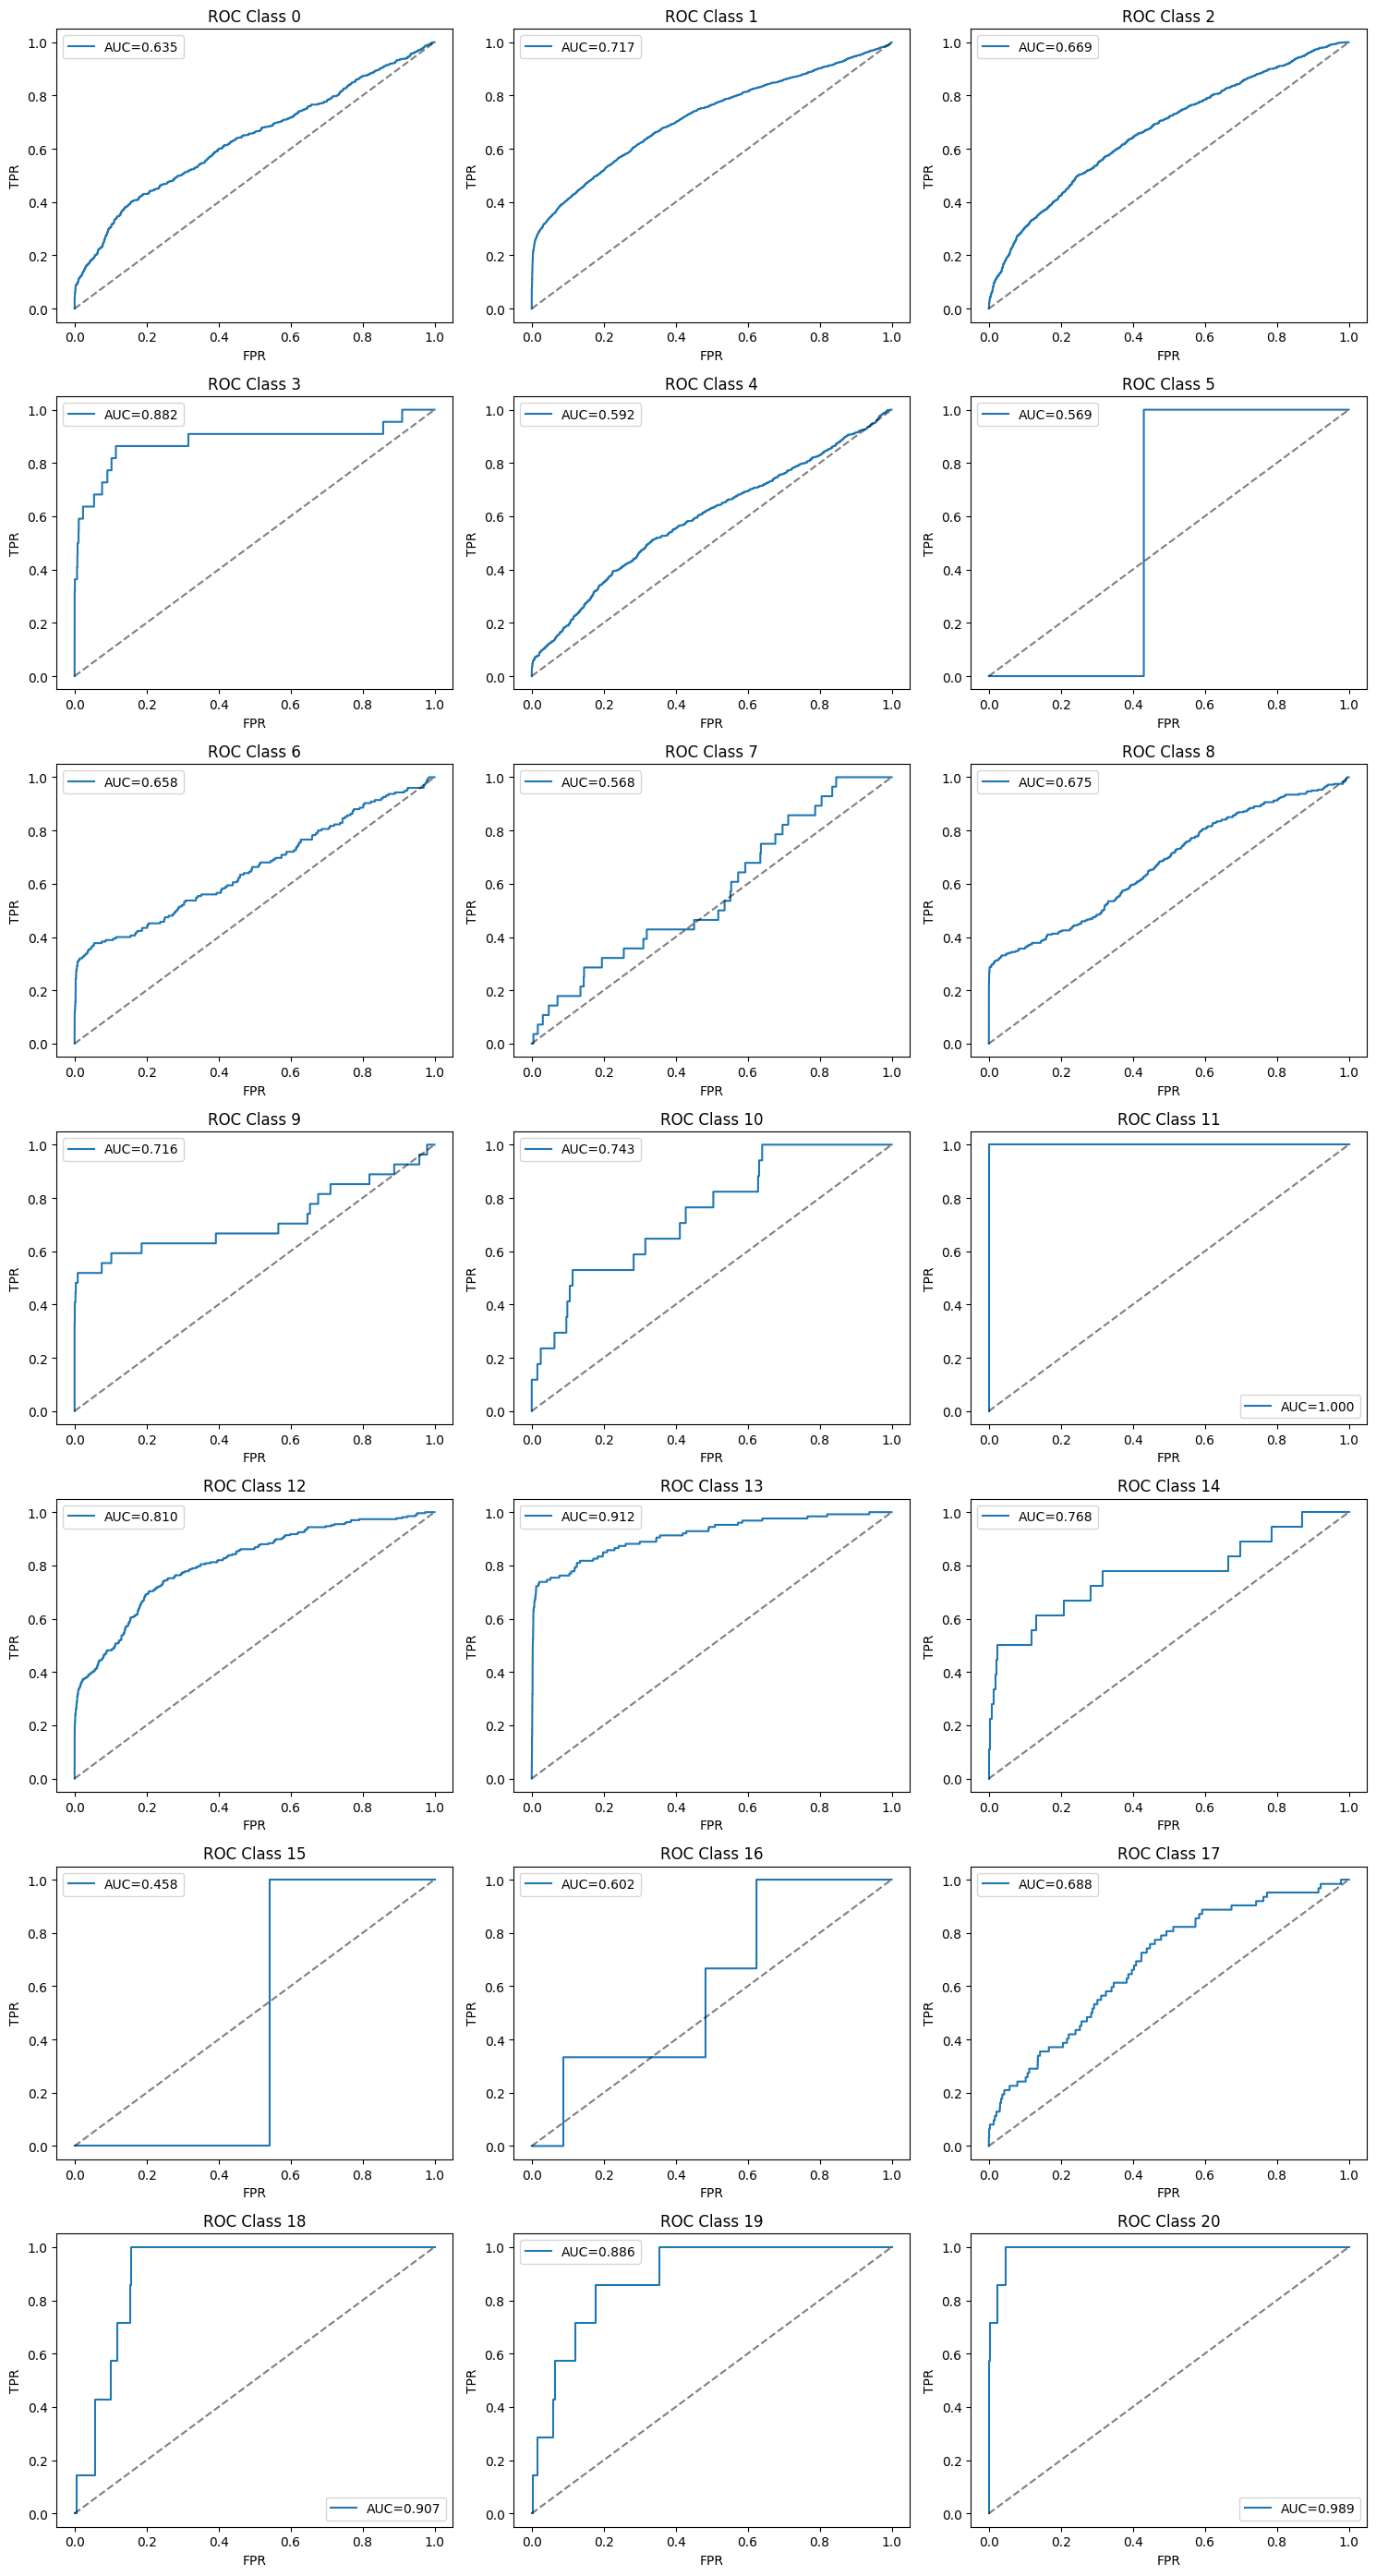

In [93]:
import math

n_classes = Y_prob.shape[1]
cols = 3                               # how many plots per row
rows = math.ceil(n_classes / cols)     # rows needed

# ---------------- ROC curves ----------------
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for j in range(n_classes):
    ax = axes[j]
    try:
        fpr, tpr, _ = roc_curve(Y_true[:, j], Y_prob[:, j])
        ax.plot(fpr, tpr, label=f"AUC={auroc_per_class[j]:.3f}")
        ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
        ax.set_title(f"ROC Class {j}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend()
    except Exception as e:
        ax.set_title(f"ROC Class {j} (error)")
        print(f"Skipping ROC for class {j}: {e}")

# Hide empty subplots (if n_classes not multiple of cols)
for k in range(n_classes, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


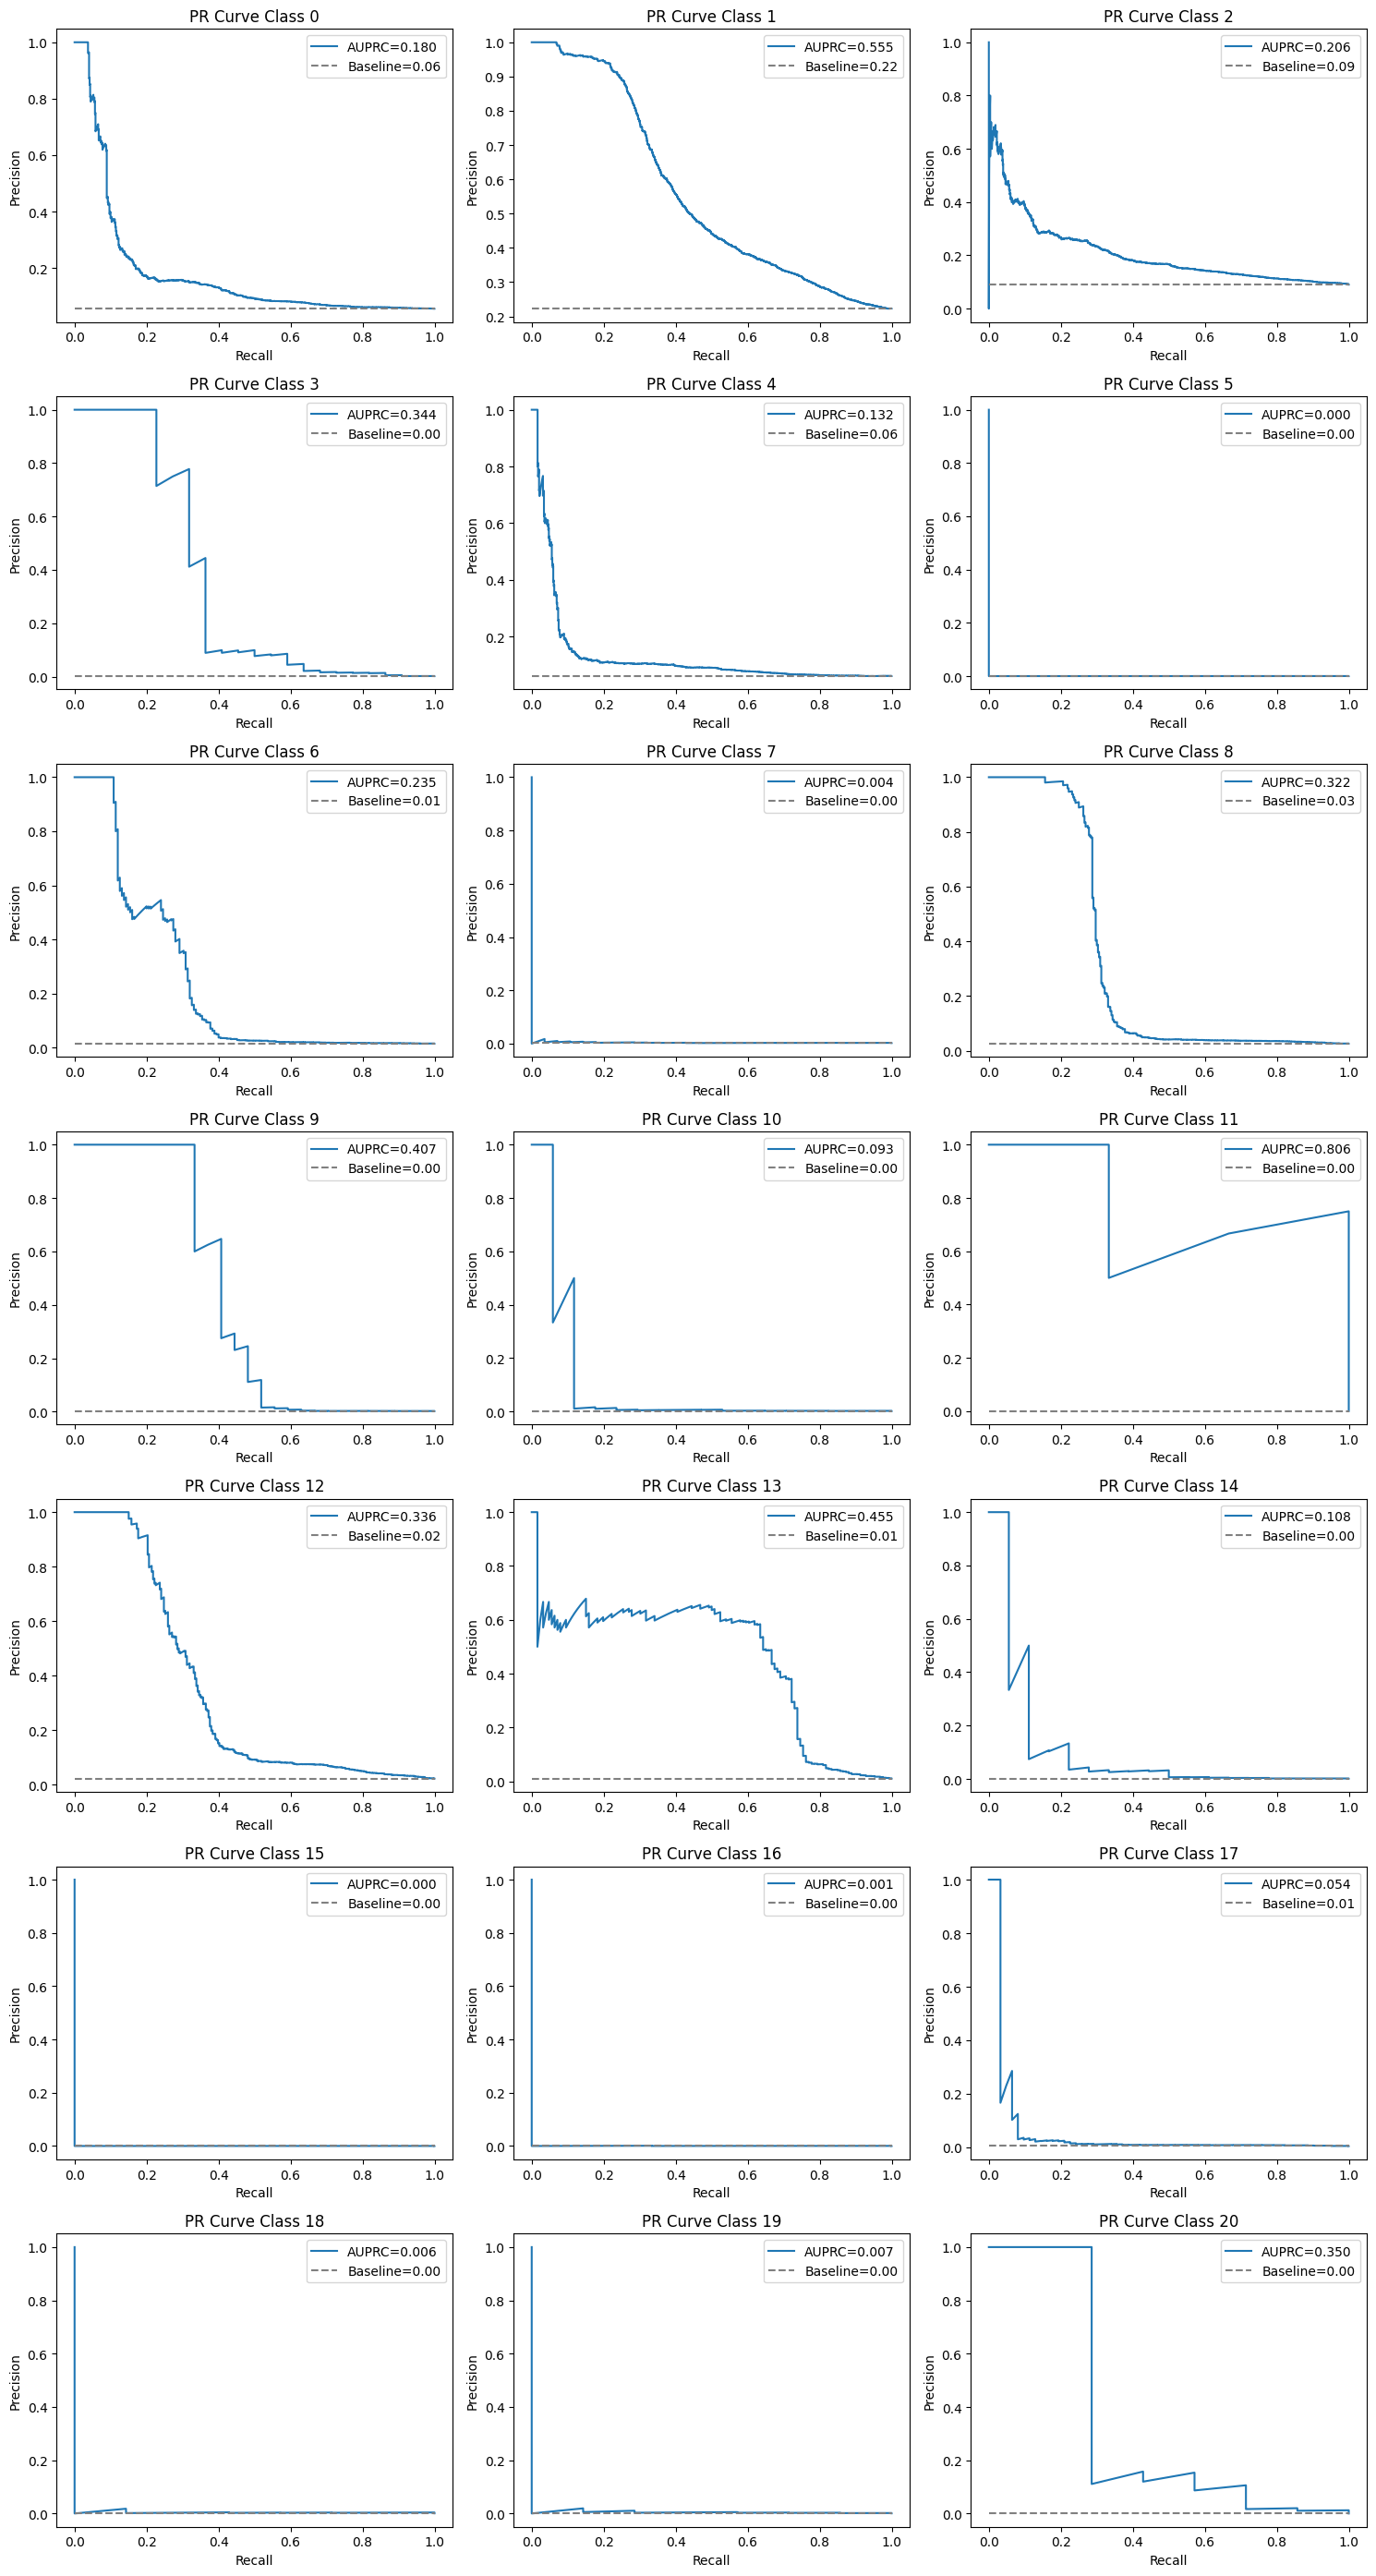

In [94]:
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for j in range(n_classes):
    ax = axes[j]
    try:
        precision, recall, _ = precision_recall_curve(Y_true[:, j], Y_prob[:, j])
        baseline = prevalence_per_class[j]
        ax.plot(recall, precision, label=f"AUPRC={auprc_per_class[j]:.3f}")
        ax.hlines(baseline, 0, 1, colors="gray", linestyles="--", label=f"Baseline={baseline:.2f}")
        ax.set_title(f"PR Curve Class {j}")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend()
    except Exception as e:
        ax.set_title(f"PR Class {j} (error)")
        print(f"Skipping PR for class {j}: {e}")

for k in range(n_classes, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

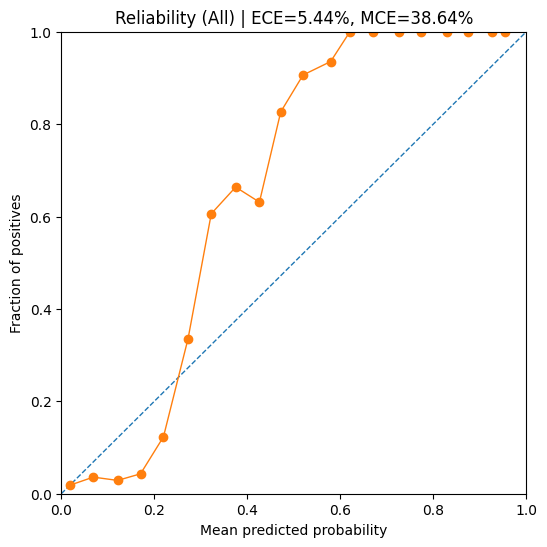

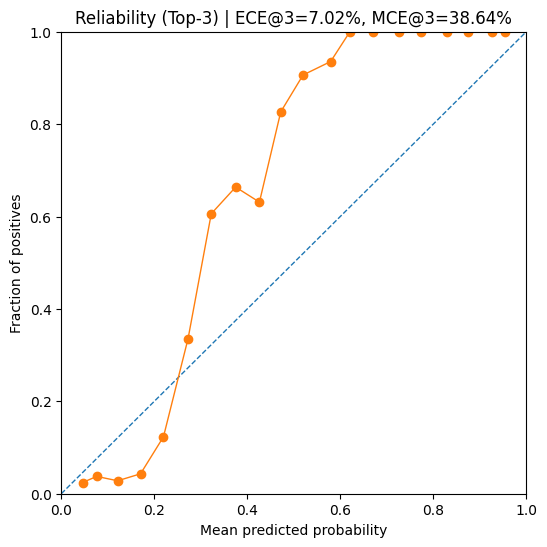

Brier: 0.02351585138565173


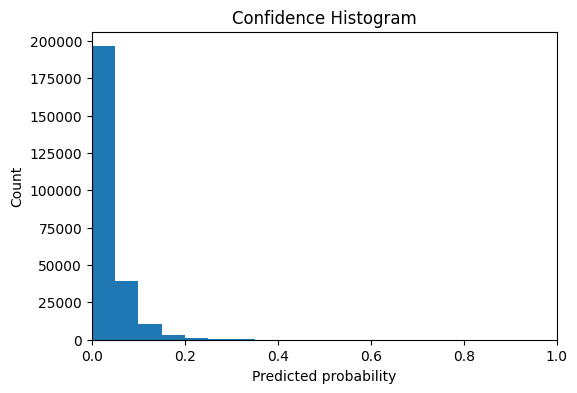

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# Extraktion aus DataFrame
# ==============================
def extract_probs_targets(df, prob_prefix="prob_class_", target_prefix="target_class_"):
    prob_cols = [c for c in df.columns if c.startswith(prob_prefix)]
    targ_cols = [c for c in df.columns if c.startswith(target_prefix)]
    if len(prob_cols) == 0 or len(targ_cols) == 0:
        raise ValueError("Keine passenden Spalten gefunden")

    def _suffix_idx(name, prefix): return int(name.replace(prefix, ""))
    prob_cols_sorted = sorted(prob_cols, key=lambda c: _suffix_idx(c, prob_prefix))
    targ_cols_sorted = sorted(targ_cols, key=lambda c: _suffix_idx(c, target_prefix))

    prob_ids = [_suffix_idx(c, prob_prefix) for c in prob_cols_sorted]
    targ_ids = [_suffix_idx(c, target_prefix) for c in targ_cols_sorted]
    if prob_ids != targ_ids:
        raise ValueError("Mismatch zwischen Prob- und Target-Spalten")

    y_prob = df[prob_cols_sorted].to_numpy(dtype=float)
    y_true = df[targ_cols_sorted].to_numpy(dtype=float)
    y_true = (y_true > 0.5).astype(int)
    y_prob = np.clip(y_prob, 0.0, 1.0)
    return y_prob, y_true

# ==============================
# Helfer für Reliability
# ==============================
def bin_stats(conf, labels, n_bins=10, quantile=False, drop_first_bin=False, min_mean_conf=None, renormalize=True):
    conf = np.asarray(conf).reshape(-1)
    labels = np.asarray(labels).reshape(-1)
    n = conf.size

    edges = (np.quantile(conf, np.linspace(0,1,n_bins+1), method="linear")
             if quantile else np.linspace(0,1,n_bins+1))
    edges[0], edges[-1] = 0.0, 1.0
    edges = np.maximum.accumulate(edges)

    bin_confs, bin_accs, bin_weights, bin_gaps = [], [], [], []
    for b in range(n_bins):
        left, right = edges[b], edges[b+1]
        m = (conf >= left) & ((conf < right) if b < n_bins-1 else (conf <= right))
        if np.any(m):
            c_mean = conf[m].mean()
            a_mean = labels[m].mean()
            w = m.sum() / n                      # Anteil an ALLEN Samples
            gap = abs(a_mean - c_mean)
        else:
            c_mean = (left + right)/2
            a_mean, w, gap = np.nan, 0.0, 0.0
        bin_confs.append(c_mean); bin_accs.append(a_mean)
        bin_weights.append(w); bin_gaps.append(gap)

    bin_confs  = np.array(bin_confs)
    bin_accs   = np.array(bin_accs)
    bin_weights= np.array(bin_weights)
    bin_gaps   = np.array(bin_gaps)

    valid = bin_weights > 0
    if drop_first_bin and np.any(valid):
        valid[0] = False
    if min_mean_conf is not None:
        valid &= (bin_confs >= float(min_mean_conf))

    if not np.any(valid):
        return bin_confs, bin_accs, bin_weights, 0.0, 0.0

    # --- entscheidend: renormalisieren ---
    if renormalize:
        w = bin_weights[valid]
        w = w / w.sum()                         # jetzt Summe = 1 über die behaltenen Bins
        ece = float(np.sum(w * bin_gaps[valid]))
    else:
        # „klassische“ ECE über alle Bins; Ausschlüsse senken den Wert mechanisch
        ece = float(np.sum(bin_weights[valid] * bin_gaps[valid]))

    mce = float(np.max(bin_gaps[valid]))
    return bin_confs, bin_accs, bin_weights, ece, mce


def brier_score(y_true, y_prob):
    return float(np.mean((y_prob - y_true) ** 2))

# ==============================
# Plot Funktionen
# ==============================
def _plot_reliability(bin_confs, bin_accs, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.plot([0,1],[0,1],"--",linewidth=1)
    mask = ~np.isnan(bin_accs)
    ax.plot(bin_confs[mask], bin_accs[mask], marker="o", linewidth=1)
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title(title)
    return ax

def plot_reliability_diagram_all(y_true, y_prob, n_bins=10, quantile=False, ax=None):
    conf, labels = y_prob.reshape(-1), y_true.reshape(-1)
    bin_confs, bin_accs, bin_weights, ece, mce = bin_stats(conf, labels, n_bins, quantile, drop_first_bin=True)
    title = f"Reliability (All) | ECE={ece*100:.2f}%, MCE={mce*100:.2f}%"
    _plot_reliability(bin_confs, bin_accs, title, ax=ax)
    return {"ECE": ece, "MCE": mce}

def plot_topk_reliability_diagram(y_true, y_prob, k=5, n_bins=10, quantile=False, ax=None):
    N,T = y_true.shape; k = min(k,T)
    idx = np.argpartition(-y_prob, kth=k-1, axis=1)[:, :k]
    rows = np.arange(N)[:,None]
    conf_topk = y_prob[rows, idx].reshape(-1)
    labels_topk = y_true[rows, idx].reshape(-1)
    bin_confs, bin_accs, bin_weights, ece, mce = bin_stats(conf_topk, labels_topk, n_bins, quantile, drop_first_bin=True)
    title = f"Reliability (Top-{k}) | ECE@{k}={ece*100:.2f}%, MCE@{k}={mce*100:.2f}%"
    _plot_reliability(bin_confs, bin_accs, title, ax=ax)
    return {"ECE@k": ece, "MCE@k": mce}

def plot_confidence_histogram(conf, n_bins=10, ax=None):
    conf = np.asarray(conf).reshape(-1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(conf, bins=n_bins, range=(0,1))
    ax.set_xlim(0,1)
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Count")
    ax.set_title("Confidence Histogram")
    return ax

# ==============================
#Wrapper für DataFrame
# ==============================
def plot_reliability_from_df(df, prob_prefix="prob_class_", target_prefix="target_class_", n_bins=10, quantile=False, ax=None):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return plot_reliability_diagram_all(y_true, y_prob, n_bins=n_bins, quantile=quantile, ax=ax)

def plot_topk_reliability_from_df(df, k=5, prob_prefix="prob_class_", target_prefix="target_class_", n_bins=10, quantile=False, ax=None):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return plot_topk_reliability_diagram(y_true, y_prob, k=k, n_bins=n_bins, quantile=quantile, ax=ax)

def brier_from_df(df, prob_prefix="prob_class_", target_prefix="target_class_"):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return brier_score(y_true, y_prob)





# Klassisches Reliability Diagram
plot_reliability_from_df(df, n_bins=20, quantile=False)
plt.show()

# Top-k Reliability Diagram 
plot_topk_reliability_from_df(df, k=3, n_bins=20, quantile=False)
plt.show()

# Brier Score
print("Brier:", brier_from_df(df))

# Histogramm über alle Wahrscheinlichkeiten
probs = df[[c for c in df.columns if c.startswith("prob_class_")]].to_numpy().ravel()
plot_confidence_histogram(probs, n_bins=20)
plt.show()
